# 2-Sample Tests Power over Increasing Dimension

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from benchmarks import power_2samp_dimension
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.sims import *

sys.path.append(os.path.realpath('..'))

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [2]:
from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """
    def __init__(self):
        self.stats = importr('stats')
        self.r_base = importr('base')
        
        numpy2ri.activate()

        self.formula = Formula('X ~ Y')
        self.env = self.formula.environment

    def _statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env['Y'] = y
        self.env['X'] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from hyppo._utils import perm_test, euclidean

from abc import ABC, abstractmethod


class RandomForestTest(ABC):
    r"""
    A base class for an random-forest based independence test.
    """

    def __init__(self):
        # set statistic and p-value
        self.stat = None
        self.pvalue = None

        super().__init__()

    @abstractmethod
    def _statistic(self, x, y):
        r"""
        Calulates the random-forest test statistic.
        Parameters
        ----------
        x, y : ndarray
            Input data matrices.
        """

    @abstractmethod
    def test(self, x, y, reps=1000, workers=1):
        r"""
        Calulates the independence test p-value.
        Parameters
        ----------
        x, y : ndarray
            Input data matrices.
        reps : int, optional
            The number of replications used in permutation, by default 1000.
        workers : int, optional (default: 1)
            Evaluates method using `multiprocessing.Pool <multiprocessing>`).
            Supply `-1` to use all cores available to the Process.
        Returns
        -------
        stat : float
            The computed independence test statistic.
        pvalue : float
            The pvalue obtained via permutation.
        """

import warnings

import numpy as np
from scipy.stats import chi2

from hyppo._utils import (
    contains_nan,
    check_ndarray_xy,
    convert_xy_float64,
    check_reps,
    # check_compute_distance,
)


class _CheckInputs:
    """Checks inputs for all independence tests"""

    def __init__(self, x, y, reps=None):
        self.x = x
        self.y = y
        self.reps = reps

    def __call__(self):
        check_ndarray_xy(self.x, self.y)
        contains_nan(self.x)
        contains_nan(self.y)
        self.x, self.y = self.check_dim_xy()
        self.x, self.y = convert_xy_float64(self.x, self.y)
        self._check_min_samples()

        if self.reps:
            check_reps(self.reps)

        return self.x, self.y

    def check_dim_xy(self):
        """Convert x and y to proper dimensions"""
        # convert arrays of type (n,) to (n, 1)
        if self.x.ndim == 1:
            self.x = self.x[:, np.newaxis]
        elif self.x.ndim != 2:
            raise ValueError(
                "Expected a 2-D array `x`, found shape " "{}".format(self.x.shape)
            )
        if self.y.ndim == 1:
            self.y = self.y[:, np.newaxis]
        elif self.y.ndim != 2 or self.y.shape[1] > 1:
            raise ValueError(
                "Expected a (n, 1) array `y`, found shape " "{}".format(self.y.shape)
            )

        self._check_nd_indeptest()

        return self.x, self.y

    def _check_nd_indeptest(self):
        """Check if number of samples is the same"""
        nx, _ = self.x.shape
        ny, _ = self.y.shape
        if nx != ny:
            raise ValueError(
                "Shape mismatch, x and y must have shape " "[n, p] and [n, q]."
            )

    def _check_min_samples(self):
        """Check if the number of samples is at least 3"""
        nx = self.x.shape[0]
        ny = self.y.shape[0]

        if nx <= 3 or ny <= 3:
            raise ValueError("Number of samples is too low")


def sim_matrix(model, x):
    terminals = model.apply(x)
    ntrees = terminals.shape[1]

    proxMat = 1 * np.equal.outer(terminals[:, 0], terminals[:, 0])
    for i in range(1, ntrees):
        proxMat += 1 * np.equal.outer(terminals[:, i], terminals[:, i])
    proxMat = proxMat / ntrees

    return proxMat

FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(RandomForestTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="classifier", ntrees=500, **kwargs):
        self.first_time = True
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("Forest must be classifier or regressor")
        RandomForestTest.__init__(self)

    def _statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        if self.first_time:
            y = y.reshape(-1)
            self.clf.fit(x, y)
            self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        y = y.reshape(-1, 1)
        disty = euclidean(y)
        stat = Dcorr(compute_distance=None)._statistic(distx, disty)
        self.stat = stat

        return stat

    def test(self, x, y, reps=1000, workers=1):
        r"""
        Calculates the random forest based Dcorr test statistic and p-value.
        """
        check_input = _CheckInputs(x, y, reps=reps)
        x, y = check_input()

        stat, pvalue, _ = perm_test(self._statistic, x, y, reps=reps, workers=workers, is_distsim=False)
        self.stat = stat
        self.pvalue = pvalue

        return stat, pvalue

In [4]:
MAX_DIMENSION = 10
STEP_SIZE = 1
DIMENSIONS = range(1, MAX_DIMENSION + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [5]:
SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
    KMERF,
    MGC,
    Dcorr,
    Hsic,
    Manova,
    HHG,
    CCA,
    RV,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [ ]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power_2samp_dimension(test, trans_2samp, sim, p=i) for _ in range(POWER_REPS)])
                          for i in DIMENSIONS])
    np.savetxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [ ]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

In [6]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [11]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Three-Sample Testing Increasing Dimension", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')
                manova_power = np.genfromtxt('../benchmarks/2samp_vs_dimension/{}_Manova.csv'.format(sim), delimiter=',')
                
                if test_name == "MGC":
                    col.plot(DIMENSIONS[2:], (power - manova_power)[2:], color="#e41a1c", label=test_name, lw=4)
                elif test_name == "KMERF":
                    col.plot(DIMENSIONS[2:], (power - manova_power)[2:], color="#e41a1c", label=test_name, lw=4, linestyle='dashed')
                elif test_name == "Manova":
                    col.plot(DIMENSIONS[2:], (power - manova_power)[2:], label=test_name, lw=4, linestyle='dashed')
                else:
                    col.plot(DIMENSIONS[2:], (power - manova_power)[2:], label=test_name, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([DIMENSIONS[2], DIMENSIONS[-1]])
                    col.set_xticklabels([3, DIMENSIONS[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.08, 'Dimension', ha='center')
    fig.text(0.08, 0.5, 'Statistical Power Relative to Manova', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../benchmarks/figs/2samp_power_dimension.pdf', transparent=True, bbox_inches='tight')

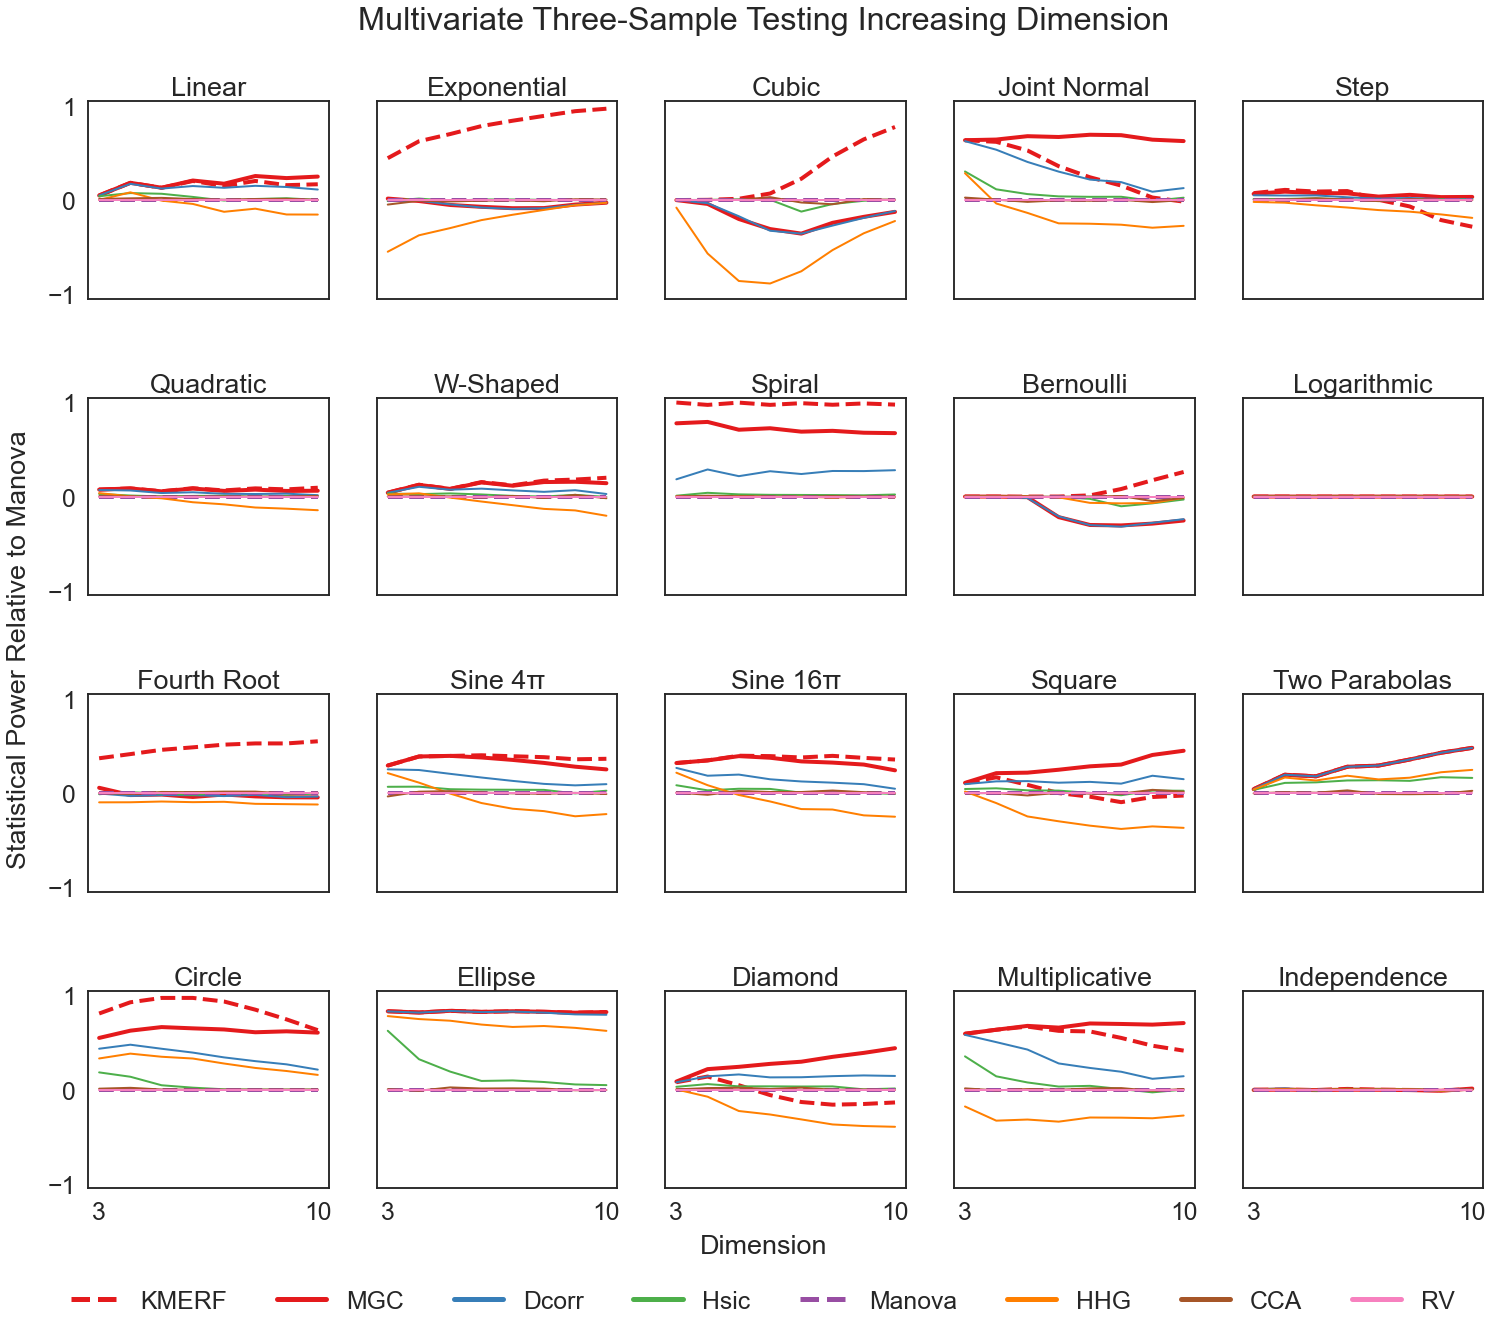

In [12]:
plot_power()